## 3. Model Definitions

Define the hyperparameters and training logic for each algorithm: Random Forest, XGBoost, LightGBM, and CatBoost.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')


sns.set(style="whitegrid")

## 1. Setup and Data Loading

Import libraries and load the master dataset.

In [65]:
df = pd.read_csv('datasets/global_master_dataset_fixed.csv')

In [66]:
yield_99 = df['Yield'].quantile(0.99)
df = df[(df['Yield'] <= yield_99) & (df['Yield'] > 0)].copy()
df['Year_Normalized'] = (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min())

In [67]:
category_counts = df['Crop_Category'].value_counts()
min_samples = 3000
valid_categories = category_counts[category_counts >= min_samples].index.tolist()

print(f"\nMajor Crop Categories (>{min_samples} samples):")
for cat in valid_categories:
    print(f"  {cat}: {category_counts[cat]:,} samples")

df_filtered = df[df['Crop_Category'].isin(valid_categories)].copy()



Major Crop Categories (>3000 samples):
  Other: 50,475 samples
  Vegetables: 18,028 samples
  Fruits: 16,978 samples
  Cereals: 12,109 samples
  Legumes: 11,880 samples
  Industrial Crops: 5,971 samples
  Root Crops: 4,748 samples
  Oil Crops: 4,301 samples


## 2. Feature Engineering

Define numerical and categorical features. We use Label Encoding for tree-based models (XGBoost/LightGBM) as they handle it well or natively.

In [68]:
numerical_features = [
    'Year_Normalized',
    'Rainfall (mm)', 
    'Temperature (C)', 
    'GDP (USD)', 
    'Agricultural Land (%)',
    'Pesticide_Total_Tonnes',
    'Fertilizer_Nutrient nitrogen N (total)',
    'Fertilizer_Nutrient phosphate P2O5 (total)',
    'Fertilizer_Nutrient potash K2O (total)'
]

categorical_features = ['Country', 'Region', 'Crop']

## Helper: Data Preparation

Function to filter data by category, log-transform targets, and apply Label Encoding to categorical features.

In [69]:
def prepare_data(df, category):
    df_cat = df[df['Crop_Category'] == category].copy()
    df_cat['Log_Yield'] = np.log1p(df_cat['Yield'])

    X = df_cat[numerical_features + categorical_features].copy()
    y = df_cat['Log_Yield']

    X_enc = X.copy()
    for col in categorical_features:
        le = LabelEncoder()
        X_enc[col] = le.fit_transform(X[col].fillna("Unknown"))

    imputer = SimpleImputer(strategy="median")
    X_enc[numerical_features] = imputer.fit_transform(X_enc[numerical_features])

    return train_test_split(X_enc, y, test_size=0.2, random_state=42)



## Random Forest

In [76]:



def train_random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=25,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    preds = np.expm1(model.predict(X_test))
    true = np.expm1(y_test)

    return preds, true, {
        "Model": "Random Forest",
        "R2": r2_score(true, preds),
        "RMSE": np.sqrt(mean_squared_error(true, preds)),
        "MAE": mean_absolute_error(true, preds)
    },model

## XGBoost

In [71]:
def train_xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    preds = np.expm1(model.predict(X_test))
    true = np.expm1(y_test)

    return preds, true, {
        "Model": "XGBoost",
        "R2": r2_score(true, preds),
        "RMSE": np.sqrt(mean_squared_error(true, preds)),
        "MAE": mean_absolute_error(true, preds)
    },model



## LightGBM

In [72]:
def train_lightgbm(X_train, X_test, y_train, y_test):
    model = lgb.LGBMRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)

    preds = np.expm1(model.predict(X_test))
    true = np.expm1(y_test)

    return preds, true, {
        "Model": "LightGBM",
        "R2": r2_score(true, preds),
        "RMSE": np.sqrt(mean_squared_error(true, preds)),
        "MAE": mean_absolute_error(true, preds)
    },model


## CatBoost

In [73]:
def train_catboost(X_train, X_test, y_train, y_test):
    model = CatBoostRegressor(
        iterations=200,
        depth=8,
        learning_rate=0.1,
        random_state=42,
        verbose=0
    )
    model.fit(X_train, y_train)

    preds = np.expm1(model.predict(X_test))
    true = np.expm1(y_test)

    return preds, true, {
        "Model": "CatBoost",
        "R2": r2_score(true, preds),
        "RMSE": np.sqrt(mean_squared_error(true, preds)),
        "MAE": mean_absolute_error(true, preds)
    },model



## 4. Model Training & Comparison

Iterate through each crop category, train all models, and record performance metrics (R², RMSE, MAE).

In [77]:
all_results = []
category_predictions = {}

for category in valid_categories:
    print(f"\n========== Category: {category} ==========")

    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data(df_filtered, category)

    category_results = {}
    rf_pred, y_true, rf_metrics, rf_model = train_random_forest(X_train, X_test, y_train, y_test)

    xgb_pred, _, xgb_metrics ,xgb_model= train_xgboost(X_train, X_test, y_train, y_test)
    lgb_pred, _, lgb_metrics ,lgb_model= train_lightgbm(X_train, X_test, y_train, y_test)
    cat_pred, _, cat_metrics ,cat_model= train_catboost(X_train, X_test, y_train, y_test)

    # Print results as you got earlier
    print(f"RF   → R²: {rf_metrics['R2']:.4f}")
    print(f"XGB  → R²: {xgb_metrics['R2']:.4f}")
    print(f"LGB  → R²: {lgb_metrics['R2']:.4f}")
    print(f"CAT  → R²: {cat_metrics['R2']:.4f}")

    # Store model performance
    all_results.extend([
        {"Category": category, **rf_metrics},
        {"Category": category, **xgb_metrics},
        {"Category": category, **lgb_metrics},
        {"Category": category, **cat_metrics}
    ])

    
    category_predictions[category] = {
        "y_test": y_true,
        "RF": rf_pred,
        "XGB": xgb_pred,
        "LGB": lgb_pred,
        "CAT": cat_pred
    }

    # Best model
    best = max([rf_metrics, xgb_metrics, lgb_metrics, cat_metrics], key=lambda x: x["R2"])
    print(f"Best Model: {best['Model']} → R² = {best['R2']:.4f}")




========== Category: Other ==========
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 40380, number of used features: 12
[LightGBM] [Info] Start training from score 7.092007
RF   → R²: 0.9264
XGB  → R²: 0.8688
LGB  → R²: 0.7922
CAT  → R²: 0.7356
Best Model: Random Forest → R² = 0.9264

========== Category: Vegetables ==========
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 14422, number of used features: 12
[LightGBM] [In

## 5. Save Best Models

Serialize the trained models for future inference.

In [89]:
import os

os.makedirs("adv_models", exist_ok=True)


In [90]:
import pickle

with open("adv_models/random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("Model saved successfully!")


Model saved successfully!


In [91]:


with open("adv_models/xgboost_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

print("Model saved successfully!")

Model saved successfully!


In [92]:


with open("adv_models/lgboost_forest_model.pkl", "wb") as f:
    pickle.dump(lgb_model, f)

print("Model saved successfully!")

Model saved successfully!


In [93]:
with open("adv_models/catboost_forest_model.pkl", "wb") as f:
    pickle.dump(cat_model, f)

print("Model saved successfully!")

Model saved successfully!


## 6. Performance Summary

Tabular view of all model results sorted by performance.

In [27]:
results_df = pd.DataFrame(overall_results)
results_df


,Category,Model,R2,RMSE,MAE
0,Other,Random Forest,0.929698,2791.341285,1065.567107
1,Other,XGBoost,0.868779,3813.549194,1667.038985
2,Other,LightGBM,0.792225,4798.709897,2095.813018
3,Other,CatBoost,0.735584,5413.423651,2414.883170
4,Vegetables,Random Forest,0.893592,4690.421453,2503.654861
5,Vegetables,XGBoost,0.855285,5469.923090,3284.788022
6,Vegetables,LightGBM,0.733728,7419.706364,4664.372878
7,Vegetables,CatBoost,0.672761,8225.390345,5164.199196
8,Fruits,Random Forest,0.839193,4932.309912,2413.604626
9,Fruits,XGBoost,0.813708,5308.792951,2930.111235


## Final Overall Comparison 

In [78]:

overall_results = []

for model_name, model_key in [('Random Forest', 'RF'), ('XGBoost', 'XGB'), 
                                ('LightGBM', 'LGB'), ('CatBoost', 'CAT')]:
    all_y_test = []
    all_y_pred = []
    
    for category in valid_categories:
        all_y_test.extend(category_predictions[category]['y_test'])
        all_y_pred.extend(category_predictions[category][model_key])
    
    all_y_test = np.array(all_y_test)
    all_y_pred = np.array(all_y_pred)
    
    overall_r2 = r2_score(all_y_test, all_y_pred)
    overall_rmse = np.sqrt(mean_squared_error(all_y_test, all_y_pred))
    overall_mae = mean_absolute_error(all_y_test, all_y_pred)
    
    overall_results.append({
        'Model': model_name,
        'R2': overall_r2,
        'RMSE': overall_rmse,
        'MAE': overall_mae
    })
    
    print(f"\n{model_name}:")
    print(f"  R²:   {overall_r2:.4f}")
    print(f"  RMSE: {overall_rmse:,.2f} kg/ha")
    print(f"  MAE:  {overall_mae:,.2f} kg/ha")



Random Forest:
  R²:   0.9198
  RMSE: 3,487.33 kg/ha
  MAE:  1,437.26 kg/ha

XGBoost:
  R²:   0.8956
  RMSE: 3,978.92 kg/ha
  MAE:  1,822.32 kg/ha

LightGBM:
  R²:   0.8254
  RMSE: 5,147.41 kg/ha
  MAE:  2,444.99 kg/ha

CatBoost:
  R²:   0.7885
  RMSE: 5,664.56 kg/ha
  MAE:  2,711.41 kg/ha


## Hyperparameter Tuning

### Random Forest — Hyperparameter Tuning

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 25, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
print("Best RF Params:", rf_grid.best_params_)



Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best RF Params: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


### XGBoost – Hyperparameter Tuning

In [80]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

xgb_param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)
print("Best XGB Params:", xgb_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGB Params: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


### LightGBM – Hyperparameter Tuning

In [81]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV

lgb_param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100, 150],
    'subsample': [0.7, 0.9, 1.0]
}

lgb_model = LGBMRegressor(random_state=42)

lgb_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_param_grid,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

lgb_search.fit(X_train, y_train)
print("Best LGB Params:", lgb_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2234
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tot

### CatBoost – Hyperparameter Tuning

In [82]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

cat_model = CatBoostRegressor(
    loss_function='RMSE',
    verbose=0,
    random_seed=42
)

cat_param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [300, 500, 800],
    'l2_leaf_reg': [1, 3, 5, 7]
}

cat_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=cat_param_grid,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

cat_search.fit(X_train, y_train)
print("Best CatBoost Params:", cat_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best CatBoost Params: {'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 800, 'depth': 10}


In [62]:
results_df = pd.DataFrame(all_results)
overall_df = pd.DataFrame(overall_results).sort_values('R2', ascending=False)

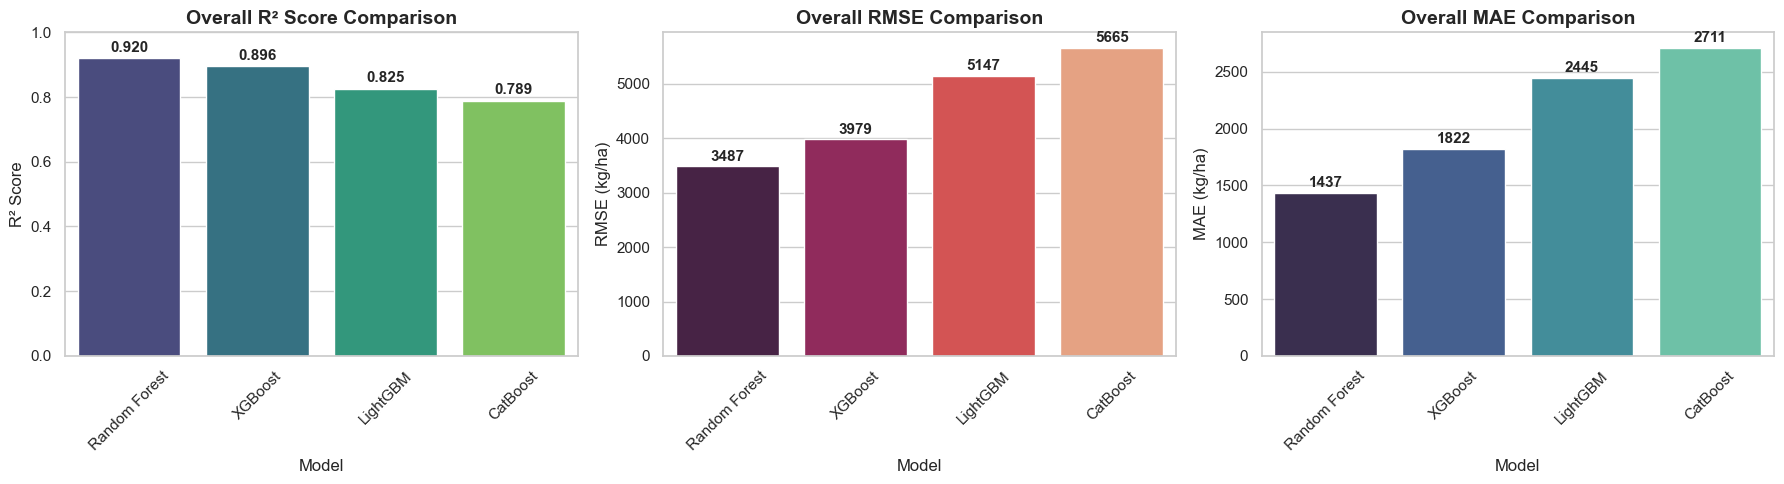

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² Score
sns.barplot(data=overall_df, x='Model', y='R2', ax=axes[0], palette='viridis')
axes[0].set_title('Overall R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=45)
for i, row in overall_df.iterrows():
    axes[0].text(i, row['R2'] + 0.02, f"{row['R2']:.3f}", ha='center', fontsize=11, fontweight='bold')

# RMSE
sns.barplot(data=overall_df, x='Model', y='RMSE', ax=axes[1], palette='rocket')
axes[1].set_title('Overall RMSE Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE (kg/ha)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
for i, row in overall_df.iterrows():
    axes[1].text(i, row['RMSE'] + 100, f"{row['RMSE']:.0f}", ha='center', fontsize=11, fontweight='bold')

# MAE
sns.barplot(data=overall_df, x='Model', y='MAE', ax=axes[2], palette='mako')
axes[2].set_title('Overall MAE Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MAE (kg/ha)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
for i, row in overall_df.iterrows():
    axes[2].text(i, row['MAE'] + 50, f"{row['MAE']:.0f}", ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

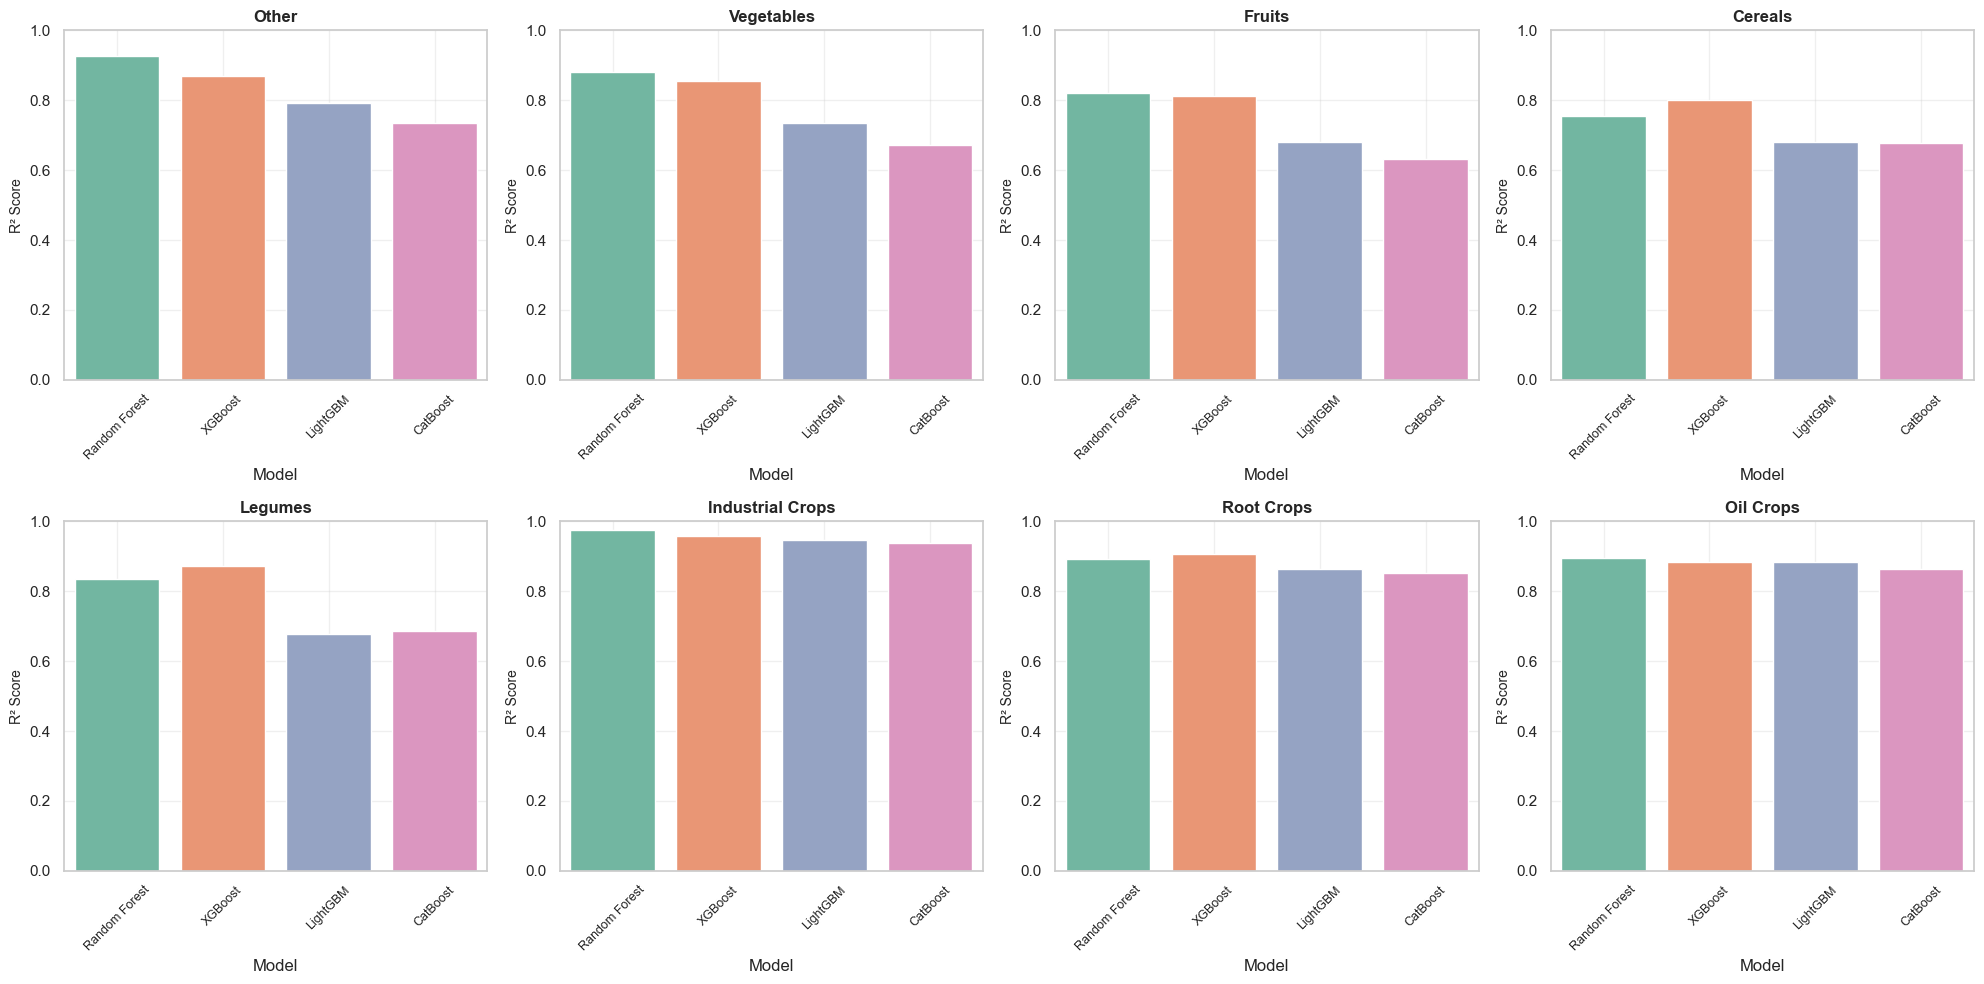

In [38]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, category in enumerate(valid_categories):
    cat_data = results_df[results_df['Category'] == category]
    
    sns.barplot(data=cat_data, x='Model', y='R2', ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{category}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('R² Score', fontsize=10)
    axes[idx].set_ylim(0, 1)
    axes[idx].tick_params(axis='x', rotation=45, labelsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

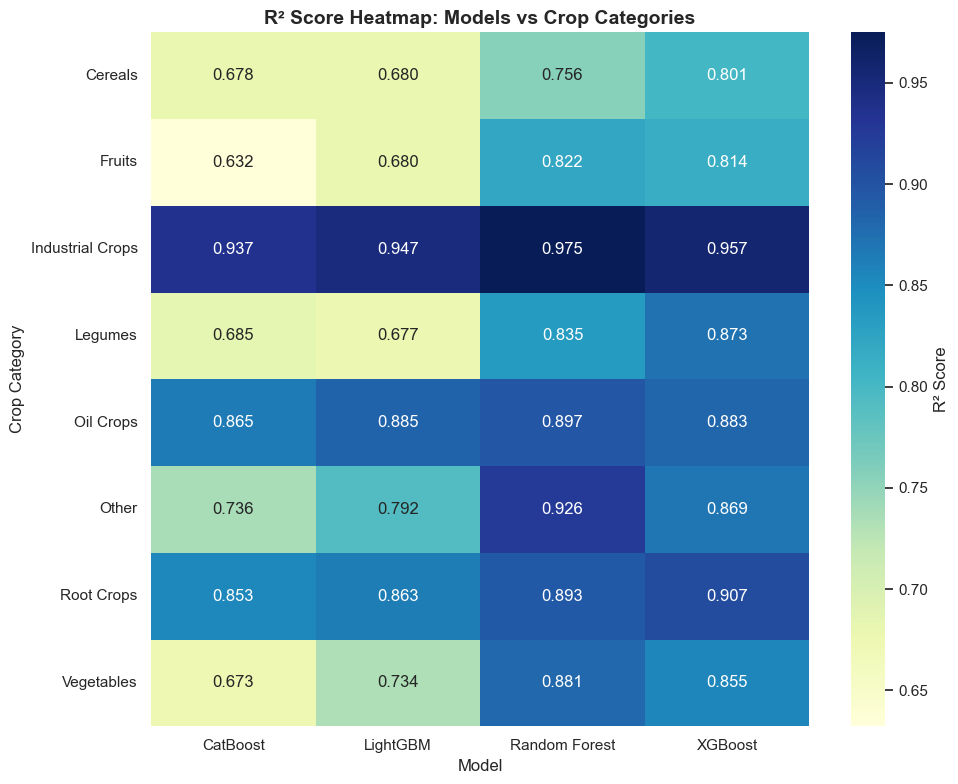

In [39]:
pivot_df = results_df.pivot(index='Category', columns='Model', values='R2')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label': 'R² Score'})
plt.title('R² Score Heatmap: Models vs Crop Categories', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Crop Category', fontsize=12)
plt.tight_layout()
plt.show()

In [40]:
best_overall = overall_df.iloc[0]
print(f"\n BEST OVERALL MODEL: {best_overall['Model']}")
print(f"   R² Score: {best_overall['R2']:.4f}")
print(f"   RMSE: {best_overall['RMSE']:,.2f} kg/ha")
print(f"   MAE: {best_overall['MAE']:,.2f} kg/ha")



 BEST OVERALL MODEL: Random Forest
   R² Score: 0.9198
   RMSE: 3,487.33 kg/ha
   MAE: 1,437.26 kg/ha


## SHAP FOR RANDOM_FOREST


Generating SHAP for Random Forest...


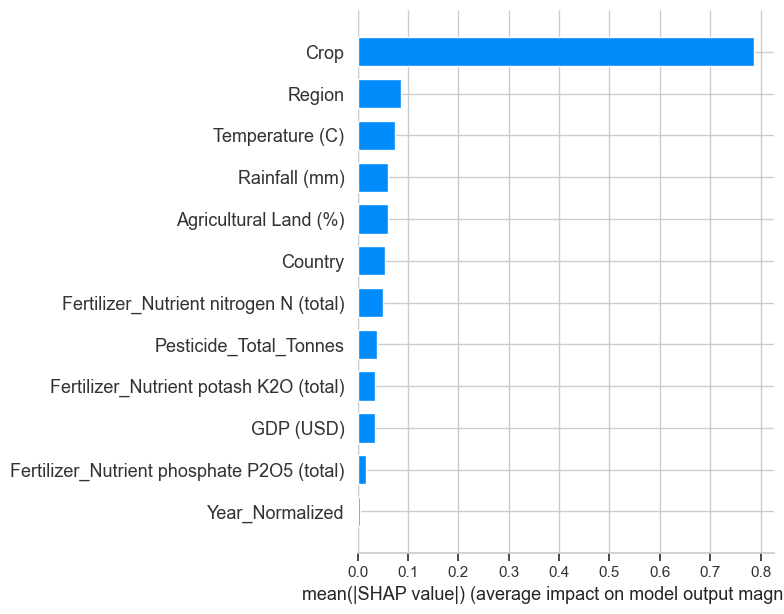

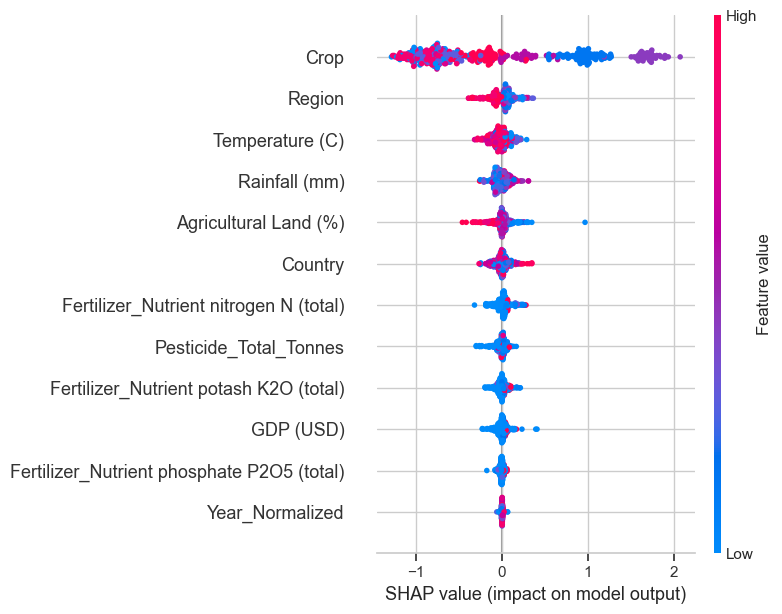

In [57]:
import shap

print("\nGenerating SHAP for Random Forest...")

X_sample = X_train[:500]     

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")


shap.summary_plot(shap_values, X_sample)




## SHAP FOR XGBOOST

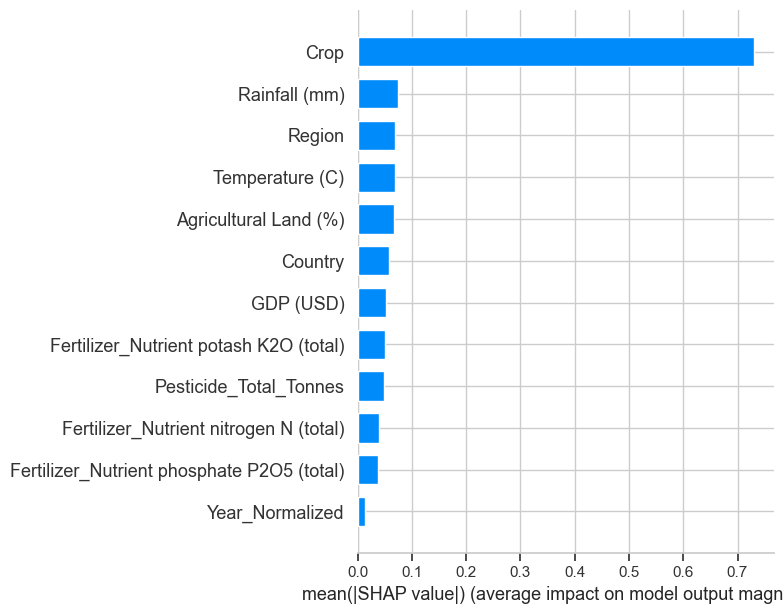

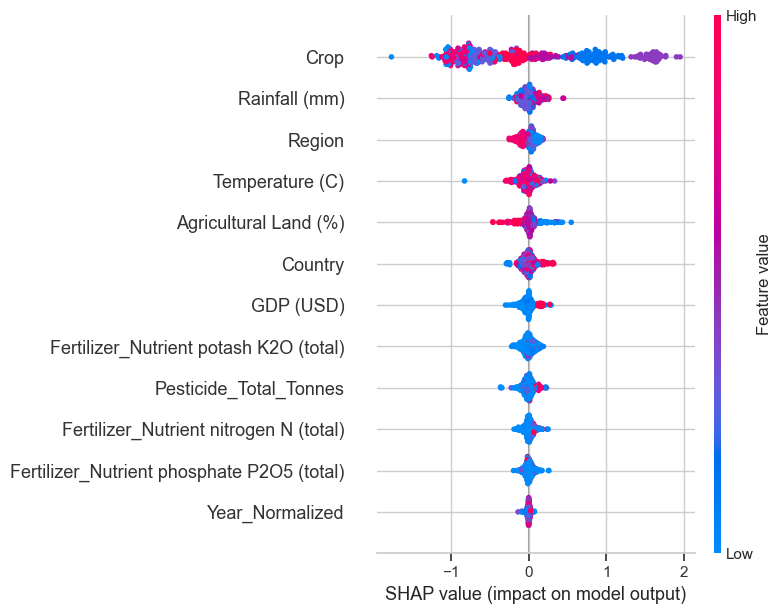

In [58]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train[:500])

shap.summary_plot(shap_values, X_train[:500], plot_type="bar")
shap.summary_plot(shap_values, X_train[:500])


## SHAP FOR LIGHTGBM

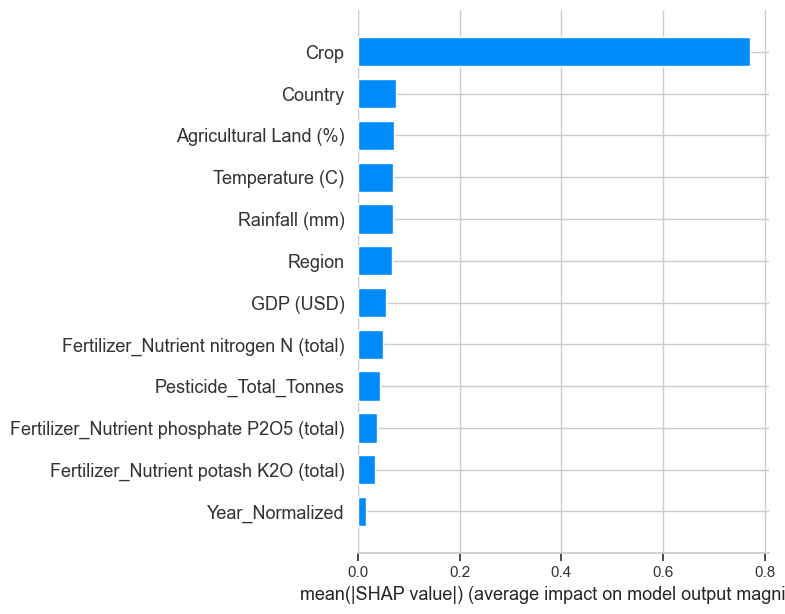

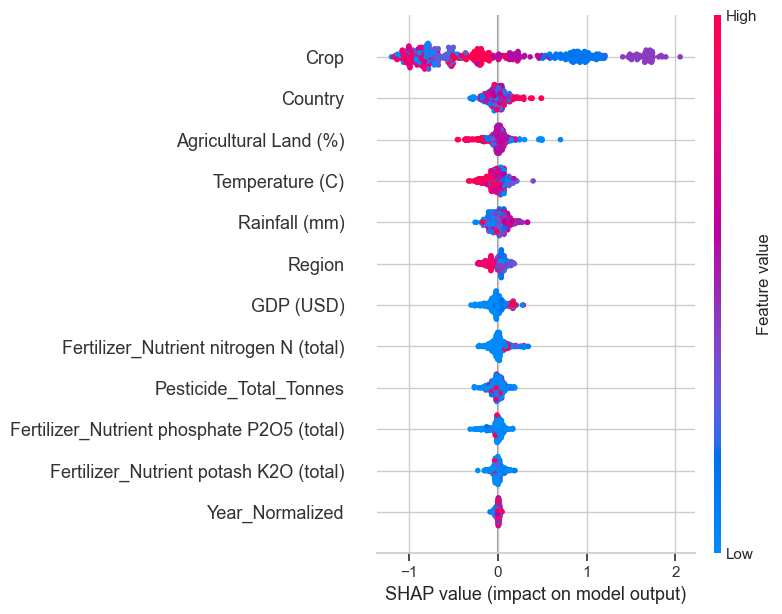

In [59]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_train[:500])

shap.summary_plot(shap_values, X_train[:500], plot_type="bar")
shap.summary_plot(shap_values, X_train[:500])


## SHAP FOR CATBOOST

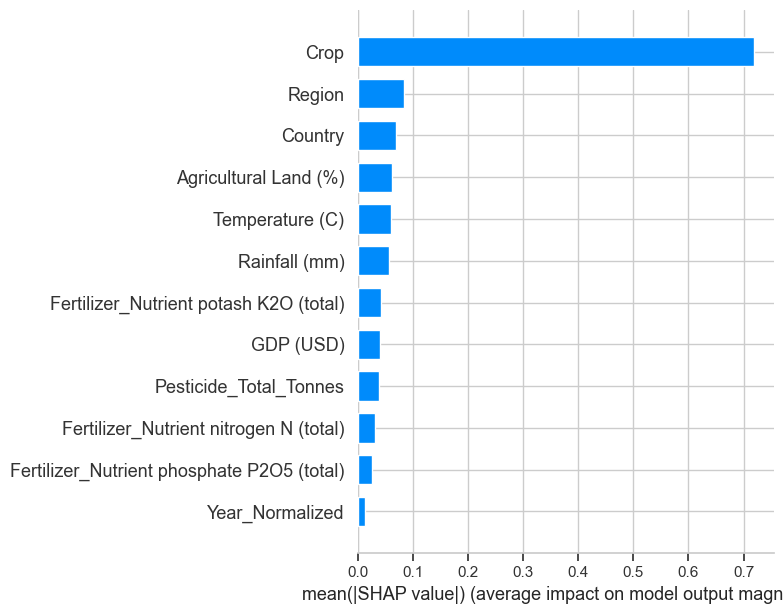

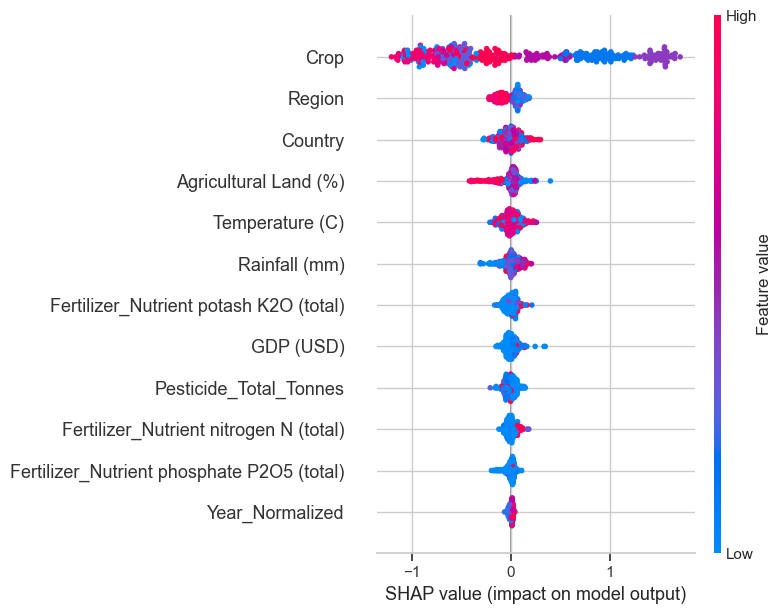

In [60]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train[:500])

shap.summary_plot(shap_values, X_train[:500], plot_type="bar")
shap.summary_plot(shap_values, X_train[:500])
